         date  temp
0  1981-01-01  20.7
1  1981-01-02  17.9
2  1981-01-03  18.8
3  1981-01-04  14.6
4  1981-01-05  15.8
5  1981-01-06  15.8
6  1981-01-07  15.8
7  1981-01-08  17.4
8  1981-01-09  21.8
9  1981-01-10  20.0
10 1981-01-11  16.2
11 1981-01-12  13.3
12 1981-01-13  16.7
13 1981-01-14  21.5
14 1981-01-15  25.0
15 1981-01-16  20.7
16 1981-01-17  20.6
17 1981-01-18  24.8
18 1981-01-19  17.7
19 1981-01-20  15.5


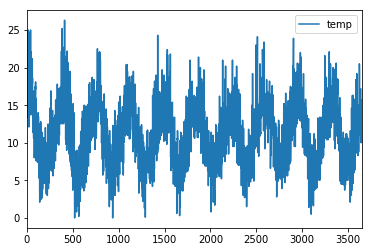

In [50]:
# line plot of time series
from pandas import Series
from pandas import DataFrame
from matplotlib import pyplot
import pandas as pd
# load dataset
series = pd.read_csv('./sequences/daily-minimum-temperatures-in-me.csv', delimiter=';', converters={"temp":float}, parse_dates=['date'])
series.head()
#df.temp.dtype = pd.np.float32
# display first few rows
#df.temp = df.temp.astype(float)
print(series.head(20))
# line plot of dataset
series.plot()
pyplot.show()

In [51]:
split_point = len(series) - 7
dataset, validation = series[0:split_point][:], series[split_point:][:]
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))
dataset.to_csv('dataset.csv')
validation.to_csv('validation.csv')

Dataset 3643, Validation 7


In [38]:
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return numpy.array(diff)

In [39]:

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

In [62]:
from pandas import Series
from statsmodels.tsa.arima_model import ARIMA
import numpy
 
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return numpy.array(diff)
 
# load dataset
#series = Series.from_csv('dataset.csv', header=None)
# seasonal difference
X = series.temp
days_in_year = 365
differenced = difference(X, days_in_year)
# fit model
model = ARIMA(differenced, order=(7,0,1))
model_fit = model.fit(disp=0)
# print summary of fit model
print(model_fit.summary())

/usr/local/lib/python3.5/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/usr/local/lib/python3.5/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 3285
Model:                     ARMA(7, 1)   Log Likelihood               -8689.286
Method:                       css-mle   S.D. of innovations              3.408
Date:                Tue, 03 Jul 2018   AIC                          17398.571
Time:                        18:47:00   BIC                          17459.542
Sample:                             0   HQIC                         17420.401
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0149      0.132      0.113      0.910      -0.244       0.274
ar.L1.y        1.1435      0.287      3.982      0.000       0.581       1.706
ar.L2.y       -0.4354      0.154     -2.834      0.0

In [48]:
dataset.temp[1]

17.9

In [63]:
forecast = model_fit.forecast()[0]
forecast = inverse_difference(X, forecast, days_in_year)

/usr/local/lib/python3.5/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


KeyError: -365

In [66]:
forecast = model_fit.forecast()[0]
# invert the differenced forecast to something usable
forecast = inverse_difference(X.values, forecast, days_in_year)
print('Forecast: %f' % forecast)

Forecast: 14.872528


In [65]:
X

0       20.7
1       17.9
2       18.8
3       14.6
4       15.8
5       15.8
6       15.8
7       17.4
8       21.8
9       20.0
10      16.2
11      13.3
12      16.7
13      21.5
14      25.0
15      20.7
16      20.6
17      24.8
18      17.7
19      15.5
20      18.2
21      12.1
22      14.4
23      16.0
24      16.5
25      18.7
26      19.4
27      17.2
28      15.5
29      15.1
        ... 
3620    13.2
3621    16.2
3622    17.3
3623    20.5
3624    20.2
3625    19.4
3626    15.5
3627    14.1
3628    11.0
3629    11.1
3630    14.0
3631    11.4
3632    12.5
3633    13.4
3634    13.6
3635    13.9
3636    17.2
3637    14.7
3638    15.4
3639    13.1
3640    13.2
3641    13.9
3642    10.0
3643    12.9
3644    14.6
3645    14.0
3646    13.6
3647    13.5
3648    15.7
3649    13.0
Name: temp, Length: 3650, dtype: float64

In [68]:
# multi-step out-of-sample forecast
forecast = model_fit.forecast(steps=7)[0]
# invert the differenced forecast to something usable
history = [x for x in X.values]
day = 1
for yhat in forecast:
	inverted = inverse_difference(history, yhat, days_in_year)
	print('Day %d: %f' % (day, inverted))
	history.append(inverted)
	day += 1

Day 1: 14.872528
Day 2: 13.395901
Day 3: 15.723570
Day 4: 14.654412
Day 5: 14.475239
Day 6: 15.462986
Day 7: 16.531543


In [71]:
plot(history)

NameError: name 'plot' is not defined